In [134]:
import numpy as np
from numpy import pi
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.visualization.utils import _get_layered_instructions

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Additional imports for audio
from time import sleep
from IPython.display import Audio, display, clear_output
from ipywidgets import widgets
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-05-19 11:02:16,265: Credentials are already in use. The existing account in the session will be replaced.


In [135]:
"""Plays a note from each column of the circuit"""

'Plays a note from each column of the circuit'

In [136]:
"""Global variables and utility functions"""

# Simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Utility functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

def get_amplitudes(matrix):
    return abs(matrix)

def get_probabilities(matrix):
    return abs(matrix**2)

def get_phases(matrix):
    return np.angle(matrix)

# Pretty-printing
def print_matrix(matrix):
    print('Matrix shape ', matrix.shape)
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_vector(vector, comment=''):
    print(f'Vector {comment} with shape {vector.shape}')
    for num in vector:
        print(np.around(num, 2))
    print('---')
    
def get_circuits_by_column(circuit):
    """circuit-splitter.ipynb"""
    # Get circuit metadata
    num_qubits = circuit.num_qubits
    num_clbits = circuit.num_clbits
    _, _, ops = _get_layered_instructions(circuit)
    num_columns = len(ops)
    
    # Initialize column information
    curr_column = [0] * num_qubits
    columns = []
    for i in range(num_columns):
        columns.append([])
        
    # Organize instructions by column
    for (insn, qargs, cargs) in circuit.data:    
        col = -1
        anchor_qubit = -1
        for qubit in qargs:
            index = qubit.index
            if curr_column[index] > col:
                col = curr_column[index]
                anchor_qubit = index
        if col == -1 or anchor_qubit == -1:
            print('Something went wrong...')
            continue

        columns[col].append((insn, qargs, cargs))
        curr_column[anchor_qubit] += 1
        for qubit in qargs:
            index = qubit.index
            curr_column[index] = curr_column[anchor_qubit]
        
    # Build the subcircuits by column
    sub_circuits = []
    for col in range(0, num_columns):
        sub_circuit = QuantumCircuit(num_qubits, num_clbits)
        for (insn, qargs, cargs) in columns[col]:
            sub_circuit.append(insn, qargs, cargs)
        sub_circuits.append(sub_circuit)

    assert len(sub_circuits) == num_columns
    return sub_circuits

"""Audio variables and functions"""

def plot_sound(x, y, frequency, xlim=None):
    """
    Plot the frequency (sound) as a visual graph.
    Optionally pass in the x-axis limits (xlim) as an array of two numbers
    """
    # Zooms in so we can actually see the waves
    if xlim and len(xlim) == 2:
        plt.xlim(xlim[0], xlim[1])
    plt.title(f'Frequency {frequency} Hz')
    plt.plot(x, y)
    
def play_notes(notes, merge=True, plot=False, volume=1.0):
    """
    :param notes: a list of tuples of form (note, frequency)
    :param merge: if True, play notes simultaneously, else sequentially
    :param plot: if True, display a graph of the frequencies
    """
    rate = 16000.0
    duration = 0.25
    x = np.linspace(0.0, duration, int(rate * duration))
    
    if merge:
        y = None
        for (note, frequency) in notes:
            yi = np.sin(frequency * 2.0 * np.pi * x)
            yi *= volume
            if y is None:
                y = yi
            else:
                y += yi

        if plot:
            plot_sound(x, y, 'chord', xlim=[0.10, 0.15])
        
        # Play sound and display widget
        display(Audio(y, rate=rate, autoplay=True))
        
    else:
        for (note, frequency) in notes:
            y = np.sin(frequency * 2.0 * np.pi * x)
            if plot:
                plot_sound(x, y, frequency, xlim=[0.10, 0.15])
            
            # Play sound and display widget
            display(Audio(y, rate=rate, autoplay=True))
            sleep(0.5) # Add delay between notes

# Start with middle C = C4
# Each note increments by a phase of pi/4
# https://pages.mtu.edu/~suits/notefreqs.html#:~:text=Frequencies%20of%20Musical%20Notes%2C%20A4%20%3D%20440%20Hz
c_scale = {
    round(0, 2): ('C4', 261.63),
    round(1*pi/4, 2): ('D4', 293.66),
    round(2*pi/4, 2): ('E4', 329.63),
    round(3*pi/4, 2): ('F4', 349.23),
    round(4*pi/4, 2): ('G4', 392.00),
    round(-3*pi/4, 2): ('A4', 440.00), # after pi, phases are negative
    round(-2*pi/4, 2): ('B4', 493.88),
    round(-1*pi/4, 2): ('C5', 523.25)
}

def get_note(phase):
    """Return music note given a phase"""
    # Round to the nearest multiple of pi/4
    base = pi/4
    key = round(base * round(phase/base), 2)
    if key not in c_scale:
        print(f'{key} not in scale!')
        return None
    
    note = c_scale[key]
    print(f'Phase {phase} maps to {note[0]}')
    return note

def get_notes(state_vector):
    notes = []
    phases = get_phases(state_vector)
    for phase in phases:
        notes.append(get_note(phase))
    
    return notes

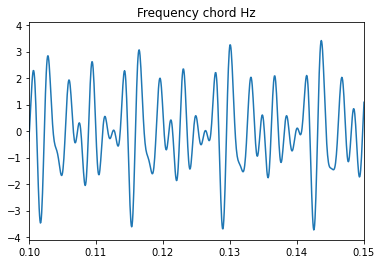

In [137]:
# Play notes at the same time
# A chord should sound not bad
d_maj_chord = [
    ('D4', 293.66),
    ('F#4', 369.99),
    ('A4', 440.00),
    ('D5', 587.33),
]
play_notes(d_maj_chord, merge=True, plot=True, volume=1)

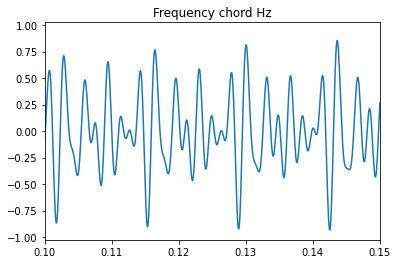

In [138]:
d_maj_chord = [
    ('D4', 293.66),
    ('F#4', 369.99),
    ('A4', 440.00),
    ('D5', 587.33),
]
play_notes(d_maj_chord, merge=True, plot=True, volume=0.25)

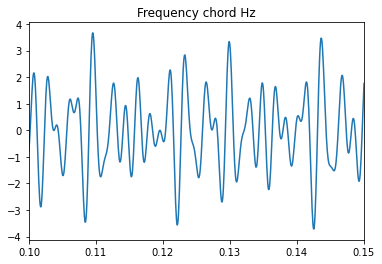

In [139]:
d_min_chord = [
    ('D4', 293.66),
    ('F4', 349.23),
    ('A4', 440.00),
    ('D5', 587.33),
]
play_notes(d_min_chord, merge=True, plot=True)

In [140]:
# Play notes sequentially
sample_tune = [
    ('A4', 440.00),
    ('A4', 440.00),
    ('A4', 440.00),
    ('F#4', 369.99),
    ('D5', 587.33),
]
play_notes(sample_tune, merge=False)

In [141]:
# Test get_note()
phases_c_scale = [
    (0, 'C4'),
    (pi/4, 'D4'),
    (pi/2, 'E4'),
    (-pi/4, 'C5'),
    (-pi/2, 'B4')
]
for (phase, note_name) in phases_c_scale:
    note = get_note(phase)
    print(f'Got {note[0]}, expected {note_name}')
    print('Correct? ', note[0] == note_name)

Phase 0 maps to C4
Got C4, expected C4
Correct?  True
Phase 0.7853981633974483 maps to D4
Got D4, expected D4
Correct?  True
Phase 1.5707963267948966 maps to E4
Got E4, expected E4
Correct?  True
Phase -0.7853981633974483 maps to C5
Got C5, expected C5
Correct?  True
Phase -1.5707963267948966 maps to B4
Got B4, expected B4
Correct?  True


4 qubits


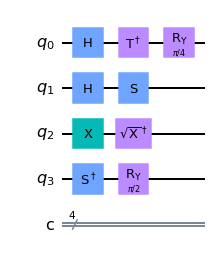

In [142]:
"""Insert circuit in this cell"""

# qasm = """
# OPENQASM 2.0;
# include "qelib1.inc";

# qreg q[2];
# creg c[2];

# h q[0];
# h q[1];
# tdg q[0];
# s q[1];
# ry(pi/4) q[0];
# ry(pi/2) q[1];
# """

qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[4];
creg c[4];

h q[0];
h q[1];
x q[2];
sdg q[3];
tdg q[0];
s q[1];
sxdg q[2];
ry(pi/4) q[0];
ry(pi/2) q[3];
"""

circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.draw()
print(f'{len(circuit.qubits)} qubits')

In [143]:
# Get circuits by column
sub_circuits = get_circuits_by_column(circuit)

<ipython-input-136-b3597a4f0695>:57: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index
<ipython-input-136-b3597a4f0695>:68: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  index = qubit.index


Vector  with shape (16,)
0j
0j
0j
0j
(0.5+0j)
(0.5+0j)
(0.5+0j)
(0.5+0j)
0j
0j
0j
0j
0j
0j
0j
0j
---
Vector phases with shape (16,)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
---
Vector probabilities with shape (16,)
0.0
0.0
0.0
0.0
0.25
0.25
0.25
0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
---


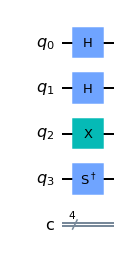

In [144]:
# Use first column as the starting state vector
state_vector = get_state_vector(sub_circuits[0])
print_vector(state_vector)

sub_circuits[0].draw()
print_vector(get_phases(state_vector), comment='phases')
print_vector(get_probabilities(state_vector), comment='probabilities')

In [145]:
# Iterate through circuit
prev_state_vector = get_state_vector(sub_circuits[0])
for i in range(1, len(sub_circuits)):
    print(f'Column {i}')
    sub_circuit = sub_circuits[i]
    unitary_matrix = get_unitary_matrix(sub_circuit)
    
    # Multiply this column's unitary matrix with previous state_vector
    state_vector = np.matmul(unitary_matrix, prev_state_vector)
    print_vector(state_vector, comment='state')
    print_vector(get_phases(state_vector), comment='phases')
    print_vector(get_probabilities(state_vector), comment='probabilities')
    
    notes = get_notes(state_vector)
    print('notes', notes)
    
    play_notes(notes)
    sleep(1) # Add some delay
        
    # Update this state vector to next iteration's prev_state_vector
    prev_state_vector = state_vector
        
    print('\n')

Column 1
Vector state with shape (16,)
(0.18+0.18j)
(0.25+0j)
(-0.18+0.18j)
(-0+0.25j)
(0.18-0.18j)
-0.25j
(0.18+0.18j)
(0.25+0j)
(0.18+0.18j)
(0.25+0j)
(-0.18+0.18j)
(-0+0.25j)
(0.18-0.18j)
-0.25j
(0.18+0.18j)
(0.25+0j)
---
Vector phases with shape (16,)
0.79
0.0
2.36
1.57
-0.79
-1.57
0.79
0.0
0.79
0.0
2.36
1.57
-0.79
-1.57
0.79
0.0
---
Vector probabilities with shape (16,)
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
0.06
---
Phase 0.7853981633974484 maps to D4
Phase 1.7225464241988335e-16 maps to C4
Phase 2.3561944901923453 maps to F4
Phase 1.5707963267948968 maps to E4
Phase -0.7853981633974483 maps to C5
Phase -1.5707963267948966 maps to B4
Phase 0.7853981633974484 maps to D4
Phase 1.1102230246251568e-16 maps to C4
Phase 0.7853981633974484 maps to D4
Phase 1.7225464241988333e-16 maps to C4
Phase 2.3561944901923453 maps to F4
Phase 1.5707963267948968 maps to E4
Phase -0.7853981633974483 maps to C5
Phase -1.5707963267948966 maps to B4
Phase 0.7853981633



Column 2
Vector state with shape (16,)
(0.07+0.16j)
(0.3+0.07j)
(-0.16+0.07j)
(-0.07+0.3j)
(0.16-0.07j)
(0.07-0.3j)
(0.07+0.16j)
(0.3+0.07j)
(0.07+0.16j)
(0.3+0.07j)
(-0.16+0.07j)
(-0.07+0.3j)
(0.16-0.07j)
(0.07-0.3j)
(0.07+0.16j)
(0.3+0.07j)
---
Vector phases with shape (16,)
1.18
0.22
2.75
1.79
-0.39
-1.35
1.18
0.22
1.18
0.22
2.75
1.79
-0.39
-1.35
1.18
0.22
---
Vector probabilities with shape (16,)
0.03
0.09
0.03
0.09
0.03
0.09
0.03
0.09
0.03
0.09
0.03
0.09
0.03
0.09
0.03
0.09
---
Phase 1.1780972450961724 maps to E4
Phase 0.22278062697166343 maps to C4
Phase 2.748893571891069 maps to G4
Phase 1.79357695376656 maps to E4
Phase -0.3926990816987242 maps to C5
Phase -1.3480156998232333 maps to B4
Phase 1.1780972450961724 maps to E4
Phase 0.22278062697166337 maps to C4
Phase 1.1780972450961724 maps to E4
Phase 0.22278062697166337 maps to C4
Phase 2.748893571891069 maps to G4
Phase 1.79357695376656 maps to E4
Phase -0.39269908169872425 maps to C5
Phase -1.3480156998232333 maps to B4
Phas